In [55]:
def par_mc_samples(df,n,reps,replace = False,random_state = 8675309, chunksize = 100):
    import dask
    import dask.dataframe as dd
    from copy import copy
    cols = copy(df.columns)
    cols = cols.insert(0,'rep')
    mc_samples_to_return = dd.from_pandas(pd.DataFrame().reindex(columns= cols),chunksize=chunksize)
    if type(df) != dask.dataframe.core.DataFrame:
        dd_df = dd.from_pandas(df,chunksize = chunksize)
    else:
        dd_df = df
    for i in range(0,reps):
        frac = n/dd_df.shape[0].compute()
        selected_samples_for_rep = dd_df.sample(frac = frac,replace=replace,random_state=random_state).compute()
        rep_number = []
        for j in range(0,n):
            rep_number.append([copy(i)])
        rep_number = dd.from_pandas(pd.DataFrame(rep_number),chunksize=chunksize)
        rep_number.columns = ['rep_number']
        selected_samples_for_rep.reset_index(drop=True, inplace=True)
        selected_samples_for_rep = dd.from_pandas(selected_samples_for_rep,chunksize = chunksize)
        selected_samples_for_rep = dd.concat([copy(rep_number),copy(selected_samples_for_rep)],axis = 1,ignore_index = True,sort = False)
        selected_samples_for_rep.columns = cols 
        mc_samples_to_return = dd.concat([copy(mc_samples_to_return),copy(selected_samples_for_rep)], axis = 0,sort=False)
        random_state += 1
    mc_samples_to_return = mc_samples_to_return.groupby(by='rep')
    return mc_samples_to_return







In [56]:
import dask
from dask import dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
df = dd.from_pandas(pd.DataFrame([[0,1],[2,3],[4,5],[6,7],[8,9]]),chunksize = 100)
#df = pd.DataFrame([[0,1],[2,3],[4,5],[6,7],[8,9]])
df.columns = ['a','b']
type(df) == dask.dataframe.core.DataFrame
# I know that the chnnksize I chose is > the size of the job. I am testing that the default of 100
# won't break something if a user submits a job smaller than 100. Maybe I am being OCD as usual.

True

In [59]:
samples = par_mc_samples(df = df, n = 100,reps = 100, replace = True)
print('success')

success


In [60]:
type(samples)

dask.dataframe.groupby.DataFrameGroupBy

In [61]:
a_sample_means = samples['a'].mean().compute()

In [122]:
# pd_samp = samples.to_csv('/home/mcguyver07/Desktop/test_test.csv')

In [62]:
type(a_sample_means)

pandas.core.series.Series

<AxesSubplot:ylabel='Density'>

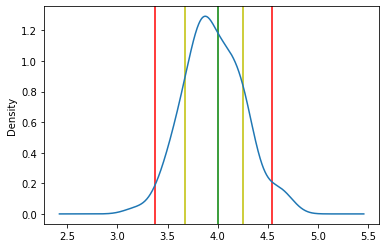

In [63]:
standard_error_hat = a_sample_means.std()
mean_of_sample_means = a_sample_means.mean()
plt.axvline(mean_of_sample_means + standard_error_hat,color='y')
plt.axvline(mean_of_sample_means - standard_error_hat,color='y')
plt.axvline(mean_of_sample_means + 2 * standard_error_hat,color='r')
plt.axvline(mean_of_sample_means - 2 * standard_error_hat,color='r')

original_sample_mean = df['a'].mean().compute()
plt.axvline(original_sample_mean, color = 'g')

a_sample_means.plot.density()


In [64]:
a_sample_means.shape

(100,)